# Modelo de deep learning baseado na memória de curto prazo (LSTM)

In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
pd.options.mode.chained_assignment = None

# Install missing packages
%pip install pandas_datareader

import yfinance as yf

#pip install tensorflow


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install --upgrade pandas_datareader


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:

acao = "PETR4.SA"

inicio = "2020-01-16"
final = "2025-01-16"

dados_acao = yf.download(acao, inicio, final)
print(dados_acao)


[*********************100%***********************]  1 of 1 completed

Price       Adj Close      Close       High        Low       Open    Volume
Ticker       PETR4.SA   PETR4.SA   PETR4.SA   PETR4.SA   PETR4.SA  PETR4.SA
Date                                                                       
2020-01-16   9.468792  29.520000  29.700001  29.330000  29.600000  28997400
2020-01-17   9.574640  29.850000  29.850000  29.540001  29.719999  34908000
2020-01-20   9.622755  30.000000  30.100000  29.650000  29.700001  31241400
2020-01-21   9.500866  29.620001  29.940001  29.549999  29.799999  28577400
2020-01-22   9.395015  29.290001  29.809999  29.270000  29.730000  32491500
...               ...        ...        ...        ...        ...       ...
2025-01-09  36.840000  36.840000  36.970001  36.700001  36.700001  11526600
2025-01-10  36.939999  36.939999  37.520000  36.900002  37.250000  40328800
2025-01-13  37.070000  37.070000  37.529999  36.970001  37.299999  22897100
2025-01-14  36.820000  36.820000  37.130001  36.580002  37.110001  29173100
2025-01-15  

In [20]:
#nao pode ser ajustados

#obtem a cotação de fechamento em um array
cotacao = dados_acao['Close'].to_numpy().reshape(-1, 1)

cotacao

array([[29.52000046],
       [29.85000038],
       [30.        ],
       ...,
       [37.06999969],
       [36.81999969],
       [37.29000092]])

In [21]:
#separa a base de treino com 80% dos dados. Poderia ter utlizado o train_test_split do sklearn e a literatura recomenda 70/30
tamanho_dados_treinamento = int(len(cotacao) * 0.8)

#imprime a quantidade de dados do vetor de treinamento
tamanho_dados_treinamento

995

In [23]:
#escalar os dados entre 0 e 1, para deixar mais fácil o processamento
#dados em escala pré definidas são mais fáceis de lidar.

escalador = MinMaxScaler(feature_range=(0, 1))

dados_entre_0_e_1_treinamento = escalador.fit_transform(cotacao[0: tamanho_dados_treinamento, :])

dados_entre_0_e_1_teste = escalador.transform(cotacao[tamanho_dados_treinamento: , :])

dados_entre_0_e_1 = list(dados_entre_0_e_1_treinamento.reshape(
    len(dados_entre_0_e_1_treinamento))) + list(dados_entre_0_e_1_teste.reshape(len(dados_entre_0_e_1_teste)))


dados_entre_0_e_1 = np.array(dados_entre_0_e_1).reshape(len(dados_entre_0_e_1), 1)

dados_entre_0_e_1

array([[0.65883632],
       [0.6707626 ],
       [0.67618362],
       ...,
       [0.931695  ],
       [0.92265994],
       [0.93964589]])

In [24]:
dados_para_treinamento = dados_entre_0_e_1[0: tamanho_dados_treinamento, :]

#dados que serão usados para gerar o resultado
treinamento_x = []
#cotação que aconteceu de fato
treinamento_y = []

#IMPORTANTE
#O modelo é treinado baseado nos últimos 60 dias para prever o próximo dia, sempre seguindo esse clico
#Ou seja, do 0 ao 59 para prever o 60, do 1 ao 60 para prever o 61, do 2 ao 61 para prever o 62 e assim por diante

for i in range(60, len(dados_para_treinamento)):

    #60 ultimos dias
    treinamento_x.append(dados_para_treinamento[i - 60: i, 0])
    #cotacao
    treinamento_y.append(dados_para_treinamento[i, 0])

    if i <= 61:

        print(treinamento_x)
        print(treinamento_y)



[array([0.65883632, 0.6707626 , 0.67618362, 0.66245036, 0.65052409,
       0.66353452, 0.65088543, 0.6049874 , 0.63281532, 0.63462237,
       0.637875  , 0.62016629, 0.61040842, 0.62667148, 0.61799783,
       0.64654864, 0.63751359, 0.64474159, 0.65739068, 0.68088181,
       0.66606433, 0.65522229, 0.65305389, 0.66714856, 0.69606071,
       0.6732924 , 0.645103  , 0.53921213, 0.50632453, 0.50777017,
       0.55077706, 0.5334297 , 0.56378749, 0.50596319, 0.4170582 ,
       0.17202745, 0.22659919, 0.16479944, 0.04734371, 0.14853631,
       0.06505241, 0.06179979, 0.        , 0.03324901, 0.02565956,
       0.00758945, 0.07083484, 0.10950487, 0.11203471, 0.07264186,
       0.07553308, 0.0975786 , 0.10878209, 0.15251176, 0.14636792,
       0.16190823, 0.18467654, 0.21792555, 0.19985544, 0.20383088])]
[0.1966028100064599]
[array([0.65883632, 0.6707626 , 0.67618362, 0.66245036, 0.65052409,
       0.66353452, 0.65088543, 0.6049874 , 0.63281532, 0.63462237,
       0.637875  , 0.62016629, 0.6104

In [25]:
#transformando as listas em arrays e dando reshape 3d

treinamento_x, treinamento_y = np.array(treinamento_x), np.array(treinamento_y)

print(treinamento_x)

treinamento_x = treinamento_x.reshape(treinamento_x.shape[0], treinamento_x.shape[1], 1)

print(treinamento_x)

[[0.65883632 0.6707626  0.67618362 ... 0.21792555 0.19985544 0.20383088]
 [0.6707626  0.67618362 0.66245036 ... 0.19985544 0.20383088 0.19660281]
 [0.67618362 0.66245036 0.65052409 ... 0.20383088 0.19660281 0.18395372]
 ...
 [0.91760033 0.95337908 0.98409835 ... 0.95627036 0.96783522 0.97144919]
 [0.95337908 0.98409835 0.9775931  ... 0.96783522 0.97144919 0.98626681]
 [0.98409835 0.9775931  0.95988433 ... 0.97144919 0.98626681 0.96891938]]
[[[0.65883632]
  [0.6707626 ]
  [0.67618362]
  ...
  [0.21792555]
  [0.19985544]
  [0.20383088]]

 [[0.6707626 ]
  [0.67618362]
  [0.66245036]
  ...
  [0.19985544]
  [0.20383088]
  [0.19660281]]

 [[0.67618362]
  [0.66245036]
  [0.65052409]
  ...
  [0.20383088]
  [0.19660281]
  [0.18395372]]

 ...

 [[0.91760033]
  [0.95337908]
  [0.98409835]
  ...
  [0.95627036]
  [0.96783522]
  [0.97144919]]

 [[0.95337908]
  [0.98409835]
  [0.9775931 ]
  ...
  [0.96783522]
  [0.97144919]
  [0.98626681]]

 [[0.98409835]
  [0.9775931 ]
  [0.95988433]
  ...
  [0.9714

In [26]:
#construindo o modelo

modelo = Sequential()

#vamos criar um modelo com 50 neurônios
#return sequences = True pois vamos usar outro LSTM depois.
#definir o shape, que no caso são 60 informações para gerar uma.
#Adicionar mais neurônios com o dense, 25 e 1
#Não se apegue a isso agora, é apenas um arquitetura de deep learning.

modelo.add(LSTM(50, return_sequences=True, input_shape = (treinamento_x.shape[1], 1)))
modelo.add(LSTM(50, return_sequences=False))
modelo.add(Dense(25))
modelo.add(Dense(1))

treinamento_x.shape[1]

c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60

In [27]:
#copilando o modelo

# a função de loss é a forma de medir o erro do modelo, que nesse caso
#é o classico erro médio quadrático da que é usado em regressão linear
#otimizador e medida de erro

modelo.compile(optimizer="adam", loss="mean_squared_error")

In [28]:
#agora com o modelo copilado e os dados, podemos treinar o modelo
#batch size é depois de quantas em quantas amostras o modelo irá otimizar os parâmetros.
#epochs é quantas vezes o algoritmo irá rodar os dados treinamento, aprendendo.

modelo.fit(treinamento_x, treinamento_y, batch_size=1, epochs=1)

935/935 ━━━━━━━━━━━━━━━━━━━━ 37s 28ms/step - loss: 0.0191


In [31]:
#criar dados de teste

dados_teste = dados_entre_0_e_1[tamanho_dados_treinamento - 60:, :]

teste_x = []
teste_y = cotacao[tamanho_dados_treinamento: , :]

for i in range(60, len(dados_teste)):
    teste_x.append(dados_teste[i - 60: i, 0])


In [32]:
#reshape
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

In [34]:
#pegando predições do modelo

predicoes = modelo.predict(teste_x)

#tirando a escala dos dados

predicoes = escalador.inverse_transform(predicoes)

len(predicoes)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


249

In [36]:
#pegando o erro médio quadrático (RMSE)

rmse = np.sqrt(np.mean(predicoes - teste_y) ** 2)
rmse
len(predicoes)

249

In [47]:
tamanho_dados_treinamento

995

In [68]:
#criando o grafico do modelo
treinamento = dados_acao.iloc[:tamanho_dados_treinamento, :]
treinamento

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA
Date,,,,,,
2020-01-16,9.468792,29.520000,29.700001,29.330000,29.600000,28997400
2020-01-17,9.574640,29.850000,29.850000,29.540001,29.719999,34908000
2020-01-20,9.622755,30.000000,30.100000,29.650000,29.700001,31241400
2020-01-21,9.500866,29.620001,29.940001,29.549999,29.799999,28577400
2020-01-22,9.395015,29.290001,29.809999,29.270000,29.730000,32491500
...,...,...,...,...,...,...
2024-01-11,31.092249,38.070000,38.150002,37.700001,37.980000,26564400
2024-01-12,31.173916,38.169998,38.730000,38.169998,38.500000,24479500


In [66]:
df_teste = pd.DataFrame({
    "Close": dados_acao['Close'].iloc[tamanho_dados_treinamento:].values.flatten(),
    "predicoes": predicoes.flatten()
})


In [70]:
df_teste

,Close,predicoes
0,37.730000,35.851833
1,37.529999,35.790913
2,37.700001,35.704617
3,38.169998,35.630474
4,37.880001,35.612514
...,...,...
244,36.840000,34.387440
245,36.939999,34.445599
246,37.070000,34.517136
247,36.820000,34.599876


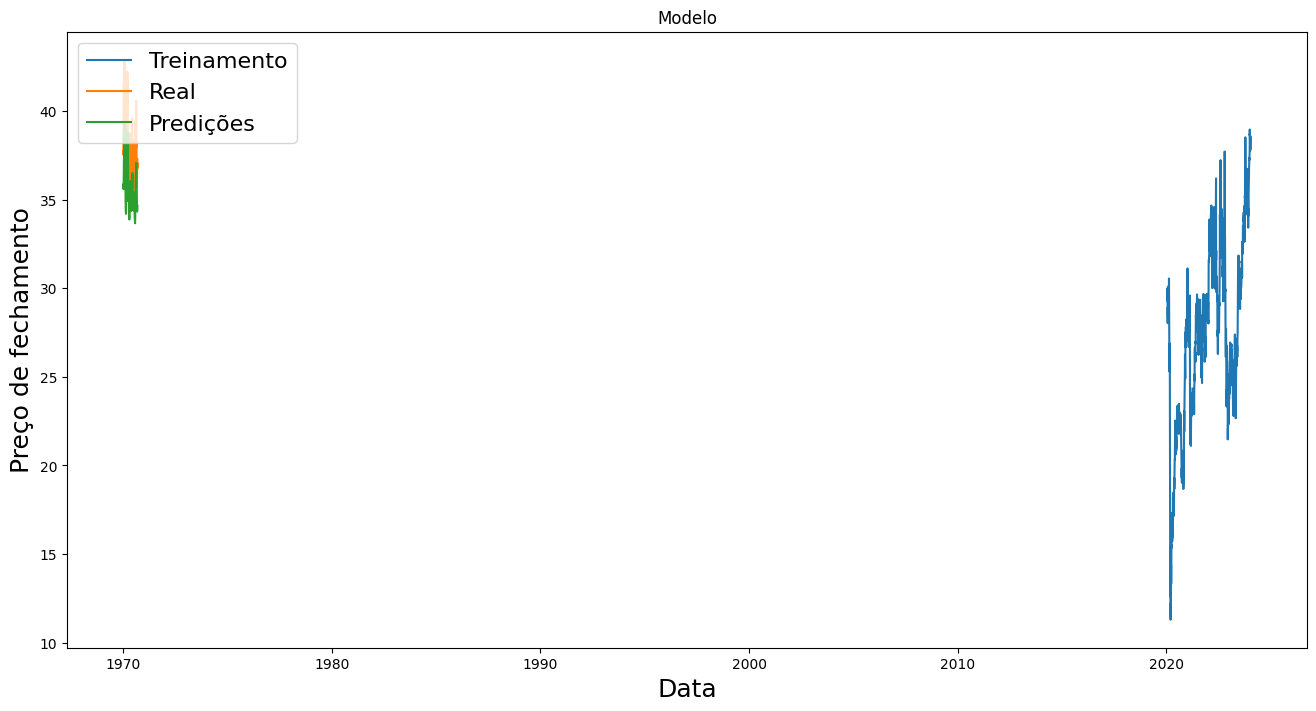

In [72]:
plt.figure(figsize =(16, 8))
plt.title('Modelo')
plt.xlabel('Data', fontsize = 18)
plt.ylabel("Preço de fechamento", fontsize = 18)
plt.plot(treinamento['Close'])
plt.plot(df_teste[['Close', 'predicoes']])
plt.legend(['Treinamento', 'Real', 'Predições'], loc=2, prop={'size': 16})
plt.show()

#essa queda pegou o modelo despevinido, pois MGLU só subia até então praticamente

In [ ]:
df_teste.sort_index()

df_teste

In [ ]:
#o preço é legal, mas o importante é acertar pra qual mercado o lado vai. Sera q isso foi feito?

#calcular media de acertos e expectativa de lucro

df_teste['variacao_percentual_acao'] = df_teste['Close'].pct_change()
df_teste['variacao_percentual_modelo'] = df_teste['predicoes'].pct_change()

df_teste = df_teste.dropna()

df_teste['var_acao_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_acao'] > 0,
                                                      True, False)
df_teste['var_modelo_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_modelo'] > 0,
                                                      True, False)

df_teste['acertou_o_lado'] = np.where(df_teste['var_acao_maior_menor_que_zero'] == df_teste['var_modelo_maior_menor_que_zero']
                                      , True, False)

df_teste['variacao_percentual_acao_abs'] = df_teste['variacao_percentual_acao'].abs()

df_teste

In [ ]:
acertou_lado = df_teste['acertou_o_lado'].sum()/len(df_teste['acertou_o_lado'])
errou_lado = 1 - acertou_lado

media_lucro = df_teste.groupby('acertou_o_lado')['variacao_percentual_acao_abs'].mean()

exp_mat_lucro = acertou_lado * media_lucro[1] - media_lucro[0] * errou_lado

ganho_sobre_perda = media_lucro[1]/media_lucro[0]

print(media_lucro)
print(ganho_sobre_perda)
print(acertou_lado)
print(exp_mat_lucro * 100)

In [ ]:
#criando um código que você passa 60 dias e ele devolve a cotação
#resumindo: vamos descobrir o preço da petrobras de hoje/amanha com esse modelo

data_hoje = datetime.now()

#se quiser escolher um dia, basta fazer assim

#data_hoje = datetime.now() - timedelta(days = 1)

if data_hoje.hour > 18:

    final = data_hoje
    inicial = datetime.now() - timedelta(days = 252)

else:
    final = data_hoje - timedelta(days = 1)
    inicial = datetime.now() - timedelta(days = 252)

#nao vai botar outra ação aqui hein kkkkkkkk
cotacoes = pdr.get_data_yahoo(acao, inicial, final)
ultimos_60_dias = cotacoes['Close'].iloc[-60:].values.reshape(-1, 1)

ultimos_60_dias_escalado = escalador.transform(ultimos_60_dias)

teste_x = []
teste_x.append(ultimos_60_dias_escalado)
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

previsao_de_preco = modelo.predict(teste_x)
previsao_de_preco = escalador.inverse_transform(previsao_de_preco)

print(previsao_de_preco)

# Sugestões:
<br>

- Melhorar as estatísticas de avaliação (dias seguidos ganhando, max DD, etc)
<br>

- Rodar pra todas as ações do ibovespa e criar uma expectativa matemática da expectativa matemática. Isso vai deixar o resultado final ainda mais robusto, definando a aloção do $ basedo na liquidez
